# Этапы работы

[1. Подготовка и предобработка данных](#step1)
 - [знакомстов и описание данных](#step1.1)
 - [подготовка и обработка данных](#step1.2)
 
[2. Обучение моделей](#step2)
 - [модель 1](#step2.1)
 - [модель 2](#step2.2)
 - [модель 3](#step2.3)
 
[3. Анализа моделей](#step3)


# Шаг 1. Подготовка данных <a id='step1'></a>

In [1]:
import pandas as pd

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as st

from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_squared_error

## Знакомство с данными и описание данных <a id='step1.1'></a>

In [2]:
autos = pd.read_csv('/datasets/autos.csv')
autos.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [4]:
autos.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


In [5]:
autos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null object
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null object
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB


In [6]:
#автомобильный кузов
autos['VehicleType'].value_counts()

sedan          91457
small          79831
wagon          65166
bus            28775
convertible    20203
coupe          16163
suv            11996
other           3288
Name: VehicleType, dtype: int64

In [7]:
#тип коробки передач
autos['Gearbox'].value_counts()

manual    268251
auto       66285
Name: Gearbox, dtype: int64

In [8]:
#модель
autos['Model'].value_counts()

golf                  29232
other                 24421
3er                   19761
polo                  13066
corsa                 12570
                      ...  
serie_2                   8
rangerover                4
serie_3                   4
serie_1                   2
range_rover_evoque        2
Name: Model, Length: 250, dtype: int64

In [9]:
#тип топлива
autos['FuelType'].value_counts()

petrol      216352
gasoline     98720
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: FuelType, dtype: int64

In [10]:
#марка автомобиля
autos['Brand'].value_counts().head()

volkswagen       77013
opel             39931
bmw              36914
mercedes_benz    32046
audi             29456
Name: Brand, dtype: int64

In [11]:
#была ли в ремонте
autos['NotRepaired'].value_counts()

no     247161
yes     36054
Name: NotRepaired, dtype: int64

In [12]:
autos.shape

(354369, 16)

## Описание данных

**Признаки**
- DateCrawled — дата скачивания анкеты из базы - не влияющий на цену автомобиля признак
- VehicleType — тип автомобильного кузова - категориальный признак, дубликатов нет, есть пропуски, около 10%, у нас нет данных, по которым можно восстановить пропуски, таких как VIN номер, например, поэтому так как набор данных достаточно большой, считаю возможном удалить строки с пропусками по этому столбцу.
- RegistrationYear — год регистрации автомобиля - пропусков нет, тип данных числовой, важный признак, влияющий на цену автомобиля. Явно есть аномальные значения, так как например минимальный год - 1000 год, макс - 9999. 
- Gearbox — тип коробки передач - есть пропуски - 5,5%, категориальный признак - механика или автомат, если не указана коробка передач, логичнее заполнить ее значением manual - соотношение manual к auto 4 к 1, т.е. 80% от всех анкет составляют автомобили с механической коробкой передач. 
- Power — мощность (л. с.) - пропусков нет, тип данных числовой, влияющий на цену автомобиля признак
- Model — модель автомобиля - категориальный признак, дубликатов нет, 5,5% пропусков - восстановить не представляется возможным, признак, влияющий на цену автомобиля
- Kilometer — пробег (км) - пропусков нет, тип данных числовой, безусловно важный признак, влияющий на цену автомобиля
- RegistrationMonth — месяц регистрации автомобиля - не влияющий на цену автомобиля признак, на мой взгляд.
- FuelType — тип топлива - категориальный признак, дубликатов нет, около 9% пропусков, 7 уникальных значений, самое популярное (67%) - petrol, считаю, что если в анкете не указан этот параметр, то тип топлива можно считать равным petrol по умолчанию, тем более в условии задачи не указана конкретная страна, будем считать, что это Россия, где большинство машин на бензине.
- Brand — марка автомобиля - пропусков нет, категориальный признак, дубликатов нет, влияющий на цену автомобиля признак
- NotRepaired — была машина в ремонте или нет - категориальный признак,дубликатов нет, 20% пропусков - очень много. По заполненным данным соотношение значений **'no'** - 87%, считаю что пустые значения можно заполнить значением **'no'**, как наиболее часто встречающимся.
- DateCreated — дата создания анкеты - не влияющий на цену автомобиля признак (у нас есть год регистрации автомобиля и пробег, дата создания анкеты, нам не важна)
- NumberOfPictures — количество фотографий автомобиля - не влияющий на цену автомобиля признак
- PostalCode — почтовый индекс владельца анкеты (пользователя) - теоретически по индексу можно найти регион, наверняка в регионах цены разные, есть справочники с инексами, к которым можно обращаться, но к сожалению, моих технических навыков пока не хватит, чтобы реализовать это, поэтому удаляем этот столбец до лучших времен.
- LastSeen — дата последней активности пользователя - не влияющий на цену автомобиля признак

**Целевой признак**
- Price — цена (евро) - по описанию данных видим, что есть нулевые значения, считаю некорректным использовать их при обучении, также ниже проверим данные на выбросы.

Посмотрим корреляцию, численных параметров не очень много:

In [13]:
def corrspearman(data):
    parameters = data
    plt.figure(figsize = (20,20))
    corr=parameters.corr(method='spearman')
    sns.heatmap(corr,annot=True, fmt=".2f")

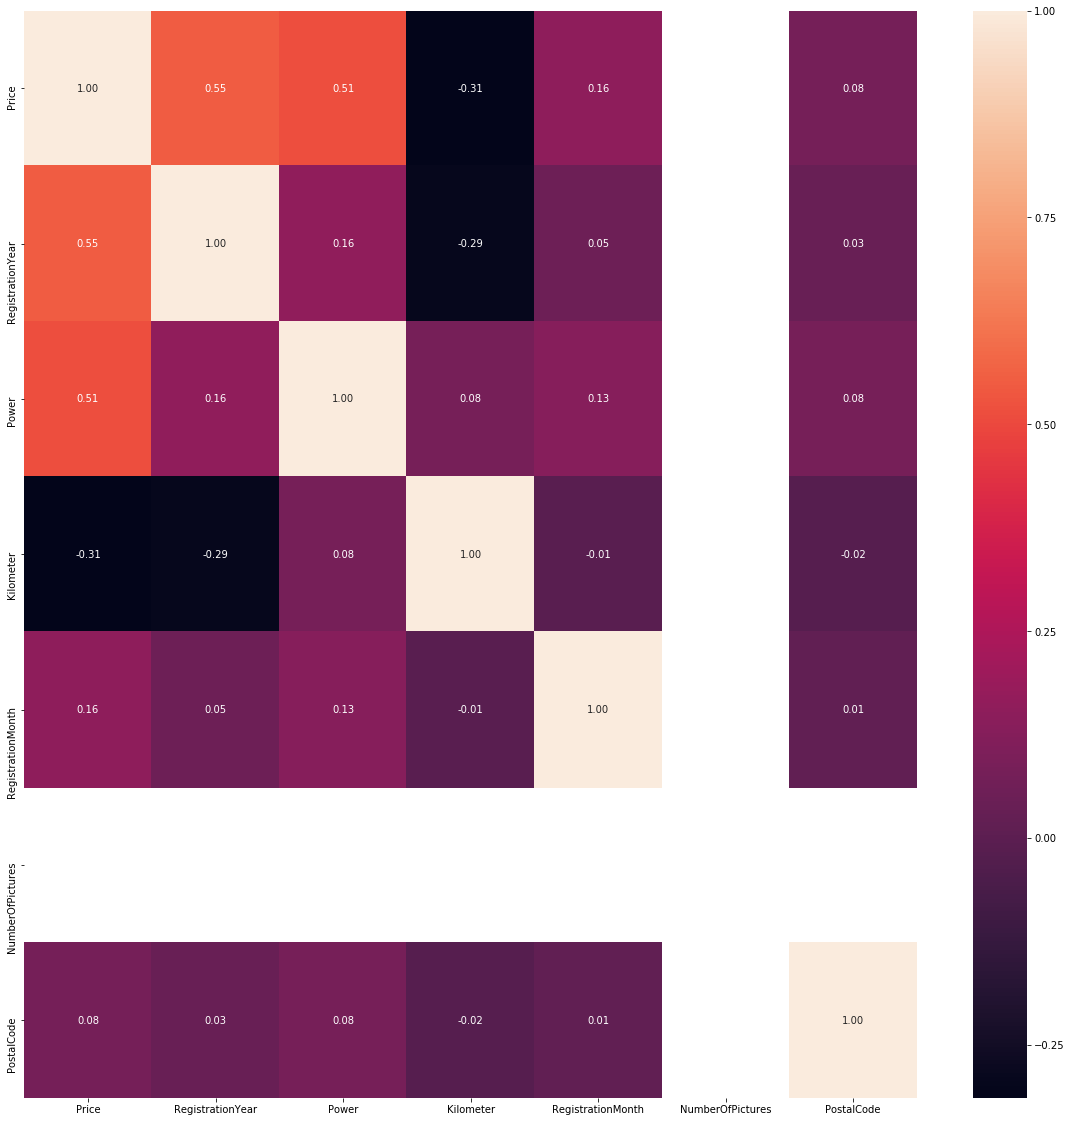

In [14]:
corrspearman(autos)

Мультиколлинеарность мужду признаками не обнаружена. Есть подобие обратной связи между признаками год регистрации и километраж - чем ранее год, тем больше километраж, что логично, но связь не сильная, все-таки кто-то активно пользуется автомобилем, а кто-то нет, поэтому оставляем оба признака для обучения.

Посмотрим на распределения данных в целевом признаке:

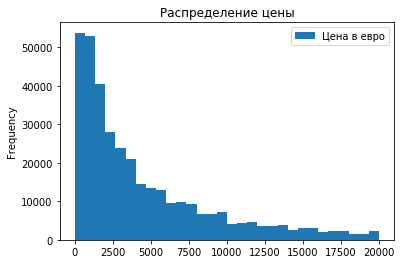

In [15]:
autos['Price'].plot(kind='hist',bins=30,legend=True,label='Цена в евро',title = 'Распределение цены')

Как уже было отмечено выше, при описании данных, встречаются нулевые значения цены, которые на мой взгляд необходимо удалить.

Также в признаке **RegistrationYear** есть аномальные значения, предлагаю оставить диапазон 1980 - 2020, автомобили более раннего периода редки или невозможны и там другое ценообразование, если это и правда уникальные раритетные автомобили. Возможно это опечатки, например при заполнении анкеты вместо 1999 - заполнили 99 и т.д., но так как количество наблюдений достаточно большое, считаю возможным удалить подобные аномалии, так как количество времени, затраченное на анализ аномальных значений и исправление их, не даст аналогичного прироста качества при обучении и предсказании моделей.

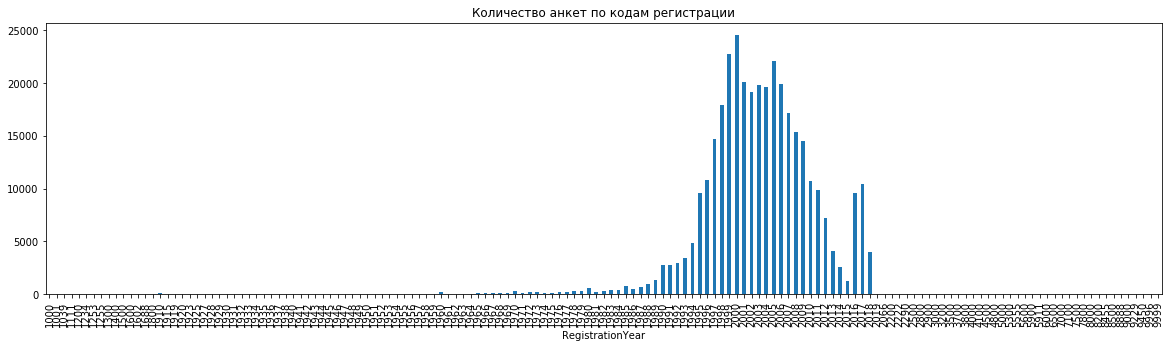

In [16]:
autos.pivot_table(index='RegistrationYear',values='Brand', aggfunc='count').plot(kind='bar', title='Количество анкет по кодам регистрации',figsize=(20, 5), legend = False)

## Обработка данных и подготовка к обучению <a id='step1.2'></a>

Удалим пропуски там, где восстановить не представляется возможными, и заполним там, где логически это возможно:

In [17]:
autos = autos.dropna(subset = ['VehicleType','Model'])
autos['Gearbox']=autos['Gearbox'].fillna('manual')
autos['NotRepaired']=autos['NotRepaired'].fillna('no')
autos['FuelType']=autos['FuelType'].fillna('petrol')
autos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 304002 entries, 2 to 354368
Data columns (total 16 columns):
DateCrawled          304002 non-null object
Price                304002 non-null int64
VehicleType          304002 non-null object
RegistrationYear     304002 non-null int64
Gearbox              304002 non-null object
Power                304002 non-null int64
Model                304002 non-null object
Kilometer            304002 non-null int64
RegistrationMonth    304002 non-null int64
FuelType             304002 non-null object
Brand                304002 non-null object
NotRepaired          304002 non-null object
DateCreated          304002 non-null object
NumberOfPictures     304002 non-null int64
PostalCode           304002 non-null int64
LastSeen             304002 non-null object
dtypes: int64(7), object(9)
memory usage: 39.4+ MB


Удалим столбцы, которые не будем использовать при обучении:

In [18]:
autos = autos.drop(['DateCrawled','RegistrationMonth','DateCreated','NumberOfPictures','PostalCode','LastSeen'], axis =1)
autos.shape

(304002, 10)

Удалим строки с нулевой ценой и аномалии в годах регистрации:

In [19]:
autos = autos.loc[(autos['RegistrationYear'] > 1980)&(autos['RegistrationYear'] < 2020)]
autos.shape

(301438, 10)

In [20]:
autos = autos.loc[autos['Price'] > 0]
autos.shape

(295465, 10)

In [21]:
autos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 295465 entries, 2 to 354368
Data columns (total 10 columns):
Price               295465 non-null int64
VehicleType         295465 non-null object
RegistrationYear    295465 non-null int64
Gearbox             295465 non-null object
Power               295465 non-null int64
Model               295465 non-null object
Kilometer           295465 non-null int64
FuelType            295465 non-null object
Brand               295465 non-null object
NotRepaired         295465 non-null object
dtypes: int64(4), object(6)
memory usage: 24.8+ MB


Применим технику OHE для преобразования категориальных перменных:

In [22]:
categoriсal = list(autos.select_dtypes(include='object').columns)
numeric = ['RegistrationYear','Kilometer']
autos_categoriсal = pd.get_dummies(autos[categoriсal], drop_first=True)
autos_categoriсal.shape

(295465, 300)

Поделим на features и target

In [23]:
features = pd.concat([autos_categoriсal, autos[numeric]],axis=1)
target = autos['Price']
features.shape

(295465, 302)

Поделим на train и test:

In [24]:
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25, random_state=12345)

In [25]:
features_train.shape

(221598, 302)

In [26]:
features_test.shape

(73867, 302)

# Шаг 2. Обучение моделей <a id='step2'></a>

Попробуем обучить несколько моделей, параметров будем подбирать немного для экономии времени.

- **случайный лес RandomForestRegressor** <a id='step2.1'></a>

Подбор параметров:

In [27]:
%%time
estimator = RandomForestRegressor(random_state=123)

param_grid = {
    'n_estimators': [20,30,40,50,60,70]
}

model = GridSearchCV(estimator, param_grid, cv=3)
model.fit(features_train, target_train)
model.best_params_

CPU times: user 54min 52s, sys: 8.75 s, total: 55min 1s
Wall time: 55min 20s


{'n_estimators': 70}

Время обучения:

In [28]:
%%time
model = RandomForestRegressor(n_estimators=70,random_state=123)
model.fit(features_train, target_train)

CPU times: user 6min 41s, sys: 528 ms, total: 6min 41s
Wall time: 6min 42s


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=70,
                      n_jobs=None, oob_score=False, random_state=123, verbose=0,
                      warm_start=False)

Скорость предсказания:

In [29]:
%%time
predictions = model.predict(features_test)

CPU times: user 2.88 s, sys: 63.9 ms, total: 2.94 s
Wall time: 2.96 s


Точность предсказания

In [30]:
mean_squared_error(target_test, predictions)**0.5

1731.8582883172373

- **линейная регрессия LinearRegression** <a id='step2.2'></a>

В линейной регрессии подбора параметров как такового и нет.

Время обучения:

In [31]:
%%time
model = LinearRegression()
model.fit(features_train, target_train)

CPU times: user 18.7 s, sys: 4.62 s, total: 23.4 s
Wall time: 23.4 s


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

Скорость предсказания

In [32]:
%%time
predictions = model.predict(features_test)

CPU times: user 110 ms, sys: 132 ms, total: 242 ms
Wall time: 217 ms


Точность предсказания:

In [33]:
mean_squared_error(target_test, predictions)**0.5

2450.8788382810144

- **градиентный бустинг LGBMRegressor** <a id='step2.3'></a>

Подбор параметров

In [34]:
%%time
estimator = LGBMRegressor()

param_grid = {
    
    'max_depth': [20,30,40],
    'num_leaves': [30,40,50]
}

modellgb = GridSearchCV(estimator, param_grid, cv=5)
modellgb.fit(features_train, target_train)
modellgb.best_params_

CPU times: user 10min 10s, sys: 17.6 s, total: 10min 28s
Wall time: 10min 35s


{'max_depth': 30, 'num_leaves': 50}

Время обучения:

In [38]:
%%time
modellgb = LGBMRegressor(num_leaves=50,max_depth=30)
modellgb.fit(features_train, target_train)

CPU times: user 14.2 s, sys: 376 ms, total: 14.6 s
Wall time: 14.7 s


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=30,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=50, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

Скорость предсказания:

In [39]:
%%time
predictions = modellgb.predict(features_test)

CPU times: user 1.46 s, sys: 84.4 ms, total: 1.55 s
Wall time: 1.51 s


Точность предсказания:

In [40]:
mean_squared_error(target_test, predictions)**0.5

1786.1424452547676

# Шаг 3. Анализ моделей <a id='step3'></a>

 У каждой модели сравним:
- качество предсказания;
- скорость предсказания;
- время обучения.

Наилучшее качество показал случайный лес. Но и по времени он обучается дольше всех, подбор параметров занимает много времени. Линейная регрессия показала худшее качество предсказаний, у нее максимальная ошибка из всех, по времени она быстрее всех, подбора парметров как такового нет. Модель градентного бустинга показала метрику ненамного хуже, чем случайный лес, хорошую скорость, гораздо меньше времени уходит и на подбор параметров и на обучение финальной модели при аналогичном качестве предсказаний. Поэтому по результатам данного исследования и анализа трех моделей можно считать градиентный бустинг LGBMRegressor оптимальной моделью.